In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np

from scipy import integrate
from python.Jfactor import *
from python.NuSpectra import *
from python.Utils import *

import matplotlib.pyplot as plt

#Change the resolution of the plots
plt.rcParams['figure.dpi']= 150

# <font color="darkmagenta"> Dark Matter Signal flux computation in equatorial coordinates </font>

In [2]:
# integration of dJ/dOmega as the function of RA, Dec
def solid_angle_integration(ra_edges, dec_edges):
    ra_edges = np.radians(ra_edges)  # Convert RA bin edges to radians
    dec_edges = np.radians(dec_edges)  # Convert Dec bin edges to radians
    
    solid_angle_array = np.zeros((len(ra_edges) - 1, len(dec_edges) - 1))  # Initialize solid angle array
    
    for i in range(len(ra_edges) - 1):
        for j in range(len(dec_edges) - 1):
            ra1, ra2 = ra_edges[i], ra_edges[i + 1]  # RA bin edges
            dec1, dec2 = dec_edges[j], dec_edges[j + 1]  # Dec bin edges
            
            # Compute solid angle
            cos_dec1 = np.cos(dec1)
            cos_dec2 = np.cos(dec2)
            omega = np.abs(np.sin(dec2) - np.sin(dec1)) * (ra2 - ra1)
            
            # Compute the Jacobian correction
            jacobian = np.abs(cos_dec2 - cos_dec1) * (ra2 - ra1)            
            solid_angle_array[i, j] = omega * jacobian  # Store solid angle with Jacobian correction
            
    return solid_angle_array

# Compute Jfactor (differential) in equatorial coordinates:
# input: bin edges in deg
def Jfactor_eq(ra_edges, dec_edges, profile, process):
    solid_angle_array = solid_angle_integration(ra_edges, dec_edges)
    ra_center = ra_edges[0:-1] + np.diff(ra_edges)/2.
    dec_center = dec_edges[0:-1] + np.diff(dec_edges)/2.
    ra_mesh, dec_mesh = np.meshgrid(ra_center, dec_center, indexing='ij')

    # corresponding open angle for each ra, dec bin
    psi_rad = psi_f(np.deg2rad(ra_mesh.flatten()), np.deg2rad(dec_mesh.flatten()))
    Jfactor_dict = Jfactor_Clumpy(profile, process)
    Jfactor = Interpolate_Jfactor(Jfactor_dict, np.rad2deg(psi_rad))

    # Correction for transfering from function in psi to function in ra and dec
    # correction factor as: (total solid angle integration in psi)/(total solid angle integration in rad, dec)
    psiint = np.linspace(0, 180, 10000)
    Jfactor_psi = Interpolate_Jfactor(Jfactor_dict, psiint)
    fint = Jfactor_psi* 2*np.pi*np.sin(np.deg2rad(psiint))
    Jfactor_psi_int = integrate.trapz(fint, np.deg2rad(psiint))

    Jfactor = Jfactor*Jfactor_psi_int/np.sum(Jfactor*solid_angle_array.flatten())
    return Jfactor.reshape(ra_mesh.shape)


In [3]:
ra_edges = np.linspace(0, 360, 200)
dec_edges = np.linspace(-90, 90, 100)

In [4]:
J = Jfactor_eq(ra_edges, dec_edges, 'Burkert', 'ann')

Text(0.5, 0, 'RA')

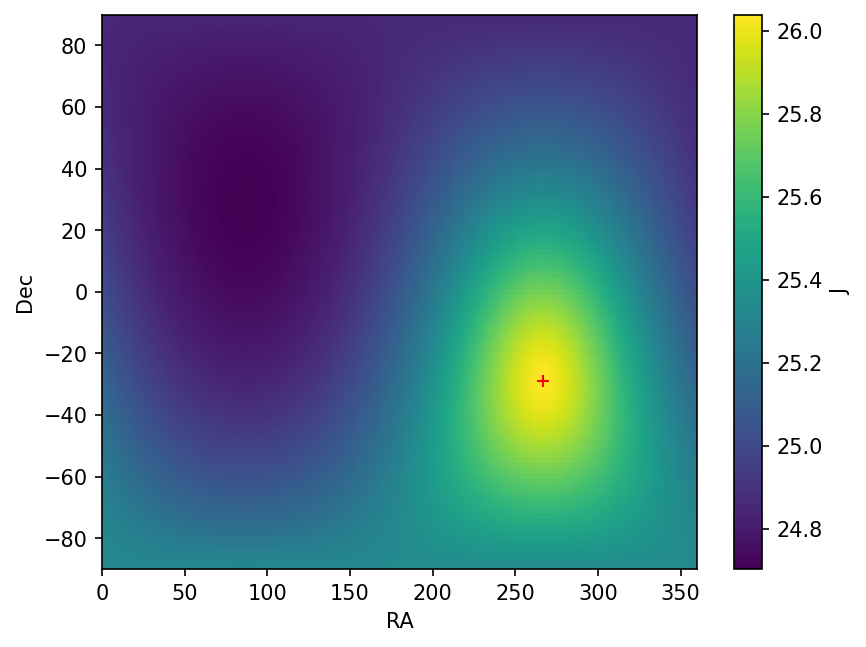

In [6]:
fig1, ax1 = plt.subplots()
mesh = ax1.pcolormesh(ra_edges, dec_edges, np.log10(J.T))
cbar = plt.colorbar(mesh)
cbar.ax.set_ylabel('J')
plt.plot(266.4167, -29.0078, marker='+', color='red')
plt.ylabel('Dec')
plt.xlabel('RA')


In [38]:
ra_center = ra_edges[0:-1] + np.diff(ra_edges)/2.
dec_center = dec_edges[0:-1] + np.diff(dec_edges)/2.
ra_mesh, dec_mesh = np.meshgrid(ra_center, dec_center, indexing='ij')
psi_rad = psi_f(np.deg2rad(ra_mesh.flatten()), np.deg2rad(dec_mesh.flatten()))
Jfactor_dict = Jfactor_Clumpy('NFW', 'ann')
Jfactor = Interpolate_Jfactor(Jfactor_dict, np.rad2deg(psi_rad))

[]

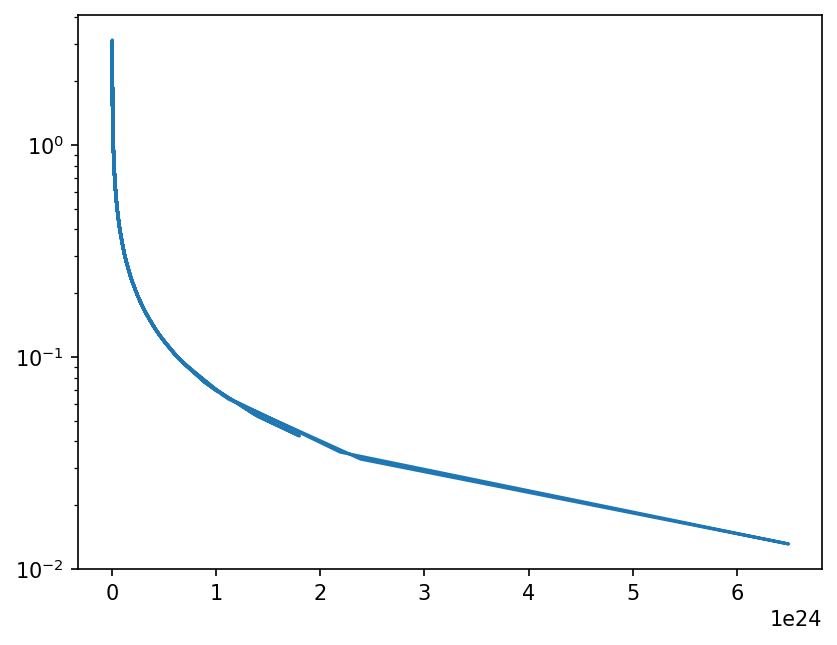

In [44]:
plt.plot(Jfactor, psi_rad)
# plt.semilogx()
plt.semilogy()

In [41]:
Jfactor

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices